In [33]:
import sqlite3
import pandas as pd
from transformers import AutoTokenizer,  AutoModelForSequenceClassification, AutoConfig, get_scheduler
import torch.nn as nn
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import os

# Preprocessing data

## Loading benchmark data

In [34]:
con = sqlite3.connect('./benchmarks/amazon_fine_food/database.sqlite')
data_train_raw_ = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 
print(data_train_raw_.shape)
data_train_raw_.head(3)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [35]:
data_train_raw_['Score'].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [36]:
data_train = pd.DataFrame(data_train_raw_[['Text', 'Score']])

In [37]:
data_train['Label'] = data_train['Score'].apply(lambda x: 'POSITIVE' if x>=4 else 'NEGATIVE' if x<=2 else 'NEUTRAL')

In [38]:
data_train.head()

,Text,Score,Label
0,I have bought several of the Vitality canned d...,5,POSITIVE
1,Product arrived labeled as Jumbo Salted Peanut...,1,NEGATIVE
2,This is a confection that has been around a fe...,4,POSITIVE
3,If you are looking for the secret ingredient i...,2,NEGATIVE
4,Great taffy at a great price. There was a wid...,5,POSITIVE


In [39]:
data_train['Label'].value_counts()

Label
POSITIVE    443777
NEGATIVE     82037
NEUTRAL      42640
Name: count, dtype: int64

In [40]:
sentiment_encoder = {'POSITIVE': 1, 'NEGATIVE':0, 'NEUTRAL':-1}

In [41]:
data_positive_train = data_train[data_train['Label']=='POSITIVE'].sample(50000, replace=False)
data_negative_train = data_train[data_train['Label']=='NEGATIVE'].sample(50000, replace=False)

data_sentiment_train = pd.concat([data_positive_train, data_negative_train])
data_sentiment_train['class'] = data_sentiment_train['Label'].apply(lambda x:sentiment_encoder[x])

In [42]:
data_sentiment_train = data_sentiment_train.rename(columns={'Text':'Review'})
data_sentiment_train = data_sentiment_train[['Review', 'class']]

## Loading manually lablled data

In [43]:
data_sentiment_test = pd.read_excel('./eval.xls')
data_sentiment_test.head()

,Review,Label
0,Japanese style Italian restaurant. Ikura Pasta...,POSITIVE
1,Definately visit this love'd their masala dosa,POSITIVE
2,I had a great experience at Meadesmoore! We or...,POSITIVE
3,Food was good! Service level was slightly belo...,POSITIVE
4,"Food, presentation and service were all top no...",POSITIVE


In [44]:
data_sentiment_test['Label'].value_counts()

Label
POSITIVE    500
NEGATIVE    500
Name: count, dtype: int64

In [45]:
data_sentiment_test['class'] = data_sentiment_test['Label'].apply(lambda x:sentiment_encoder[x])
data_sentiment_test.head()

,Review,Label,class
0,Japanese style Italian restaurant. Ikura Pasta...,POSITIVE,1
1,Definately visit this love'd their masala dosa,POSITIVE,1
2,I had a great experience at Meadesmoore! We or...,POSITIVE,1
3,Food was good! Service level was slightly belo...,POSITIVE,1
4,"Food, presentation and service were all top no...",POSITIVE,1


In [46]:
data_sentiment_test = data_sentiment_test[['Review', 'class']]
data_sentiment_test.head()

,Review,class
0,Japanese style Italian restaurant. Ikura Pasta...,1
1,Definately visit this love'd their masala dosa,1
2,I had a great experience at Meadesmoore! We or...,1
3,Food was good! Service level was slightly belo...,1
4,"Food, presentation and service were all top no...",1


# Sentiment Training

## Data Prep

In [47]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
def tokenize_function(examples, col):
    return tokenizer(examples[col], padding=True, truncation=True, max_length=512,return_tensors='pt')

In [48]:
train_dataset = Dataset.from_pandas(data_sentiment_train)
test_dataset = Dataset.from_pandas(data_sentiment_test)

In [49]:
train_dataset = train_dataset.map(lambda x:tokenize_function(x,'Review'), batched=True)
test_dataset = test_dataset.map(lambda x:tokenize_function(x,'Review'), batched=True)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 15244.59 examples/s]


In [50]:
def format_tokenized_datasets(dataset):
    dataset = dataset.remove_columns(['Review'])
    dataset = dataset.rename_column('class', 'labels')
    dataset.set_format('torch')
    return dataset

train_dataset = format_tokenized_datasets(train_dataset)
test_dataset = format_tokenized_datasets(test_dataset)

In [51]:
indexes = np.arange(len(train_dataset))
np.random.shuffle(indexes)
train_index = indexes[:int(0.8*len(train_dataset))]
val_index = indexes[int(0.8*len(train_dataset)):]

train_dataloader = DataLoader(train_dataset.select(train_index), shuffle=True, batch_size=8)
val_dataloader = DataLoader(train_dataset.select(val_index), shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=8)

## Model Prep

In [52]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'

device = torch.device(device)

In [53]:
def build_model():
    config = AutoConfig.from_pretrained(MODEL)
    model =  AutoModelForSequenceClassification.from_pretrained(MODEL, config=config)
    model.classifier.out_proj = nn.Sequential(
        nn.Linear(
            in_features=768,
            out_features=2,
            bias=True
        ),
        nn.Softmax()
    )

    # for param in model.roberta.parameters():
    #     param.requires_grad=False

    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)

    return model

In [54]:
num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
model = build_model()
optimizer = Adam(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

loss_fn = torch.nn.BCELoss()
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Sentiment Training on benchmark dataset

In [55]:
results = {'precision':[], 'recall':[], 'f1': []}
best_f1 = 0
max_patience = 2

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    samples = 0
    for batch in tqdm(train_dataloader):
        if samples>=10000:
            break
        samples += 8
        inputs = {k: v.to(device) for k, v in batch.items() if k!='labels' and k!='__index_level_0__'}
        target = F.one_hot(batch['labels'], num_classes=2).to(torch.float).to(device)
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, target)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    print(total_loss/len(train_dataloader))

    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        samples = 0
        for batch in tqdm(val_dataloader):
            inputs = {k: v.to(device) for k, v in batch.items() if k!='labels' and k!='__index_level_0__'}
            target = F.one_hot(batch['labels'], num_classes=2).to(torch.float)
            outputs = model(**inputs).logits.detach().cpu().numpy()

            pred.append(outputs[:, 1])
            true.append(batch['labels'].numpy())

        true = np.hstack(true)
        pred = np.hstack(pred)
        precision = precision_score(true, np.round(pred), average='macro')
        recall = recall_score(true, np.round(pred), average='macro')
        f1 = f1_score(true, np.round(pred), average='macro')
        print("Precision:", precision)
        print("Recall:", recall)
        print("F-measure:", f1)
        
        if f1>best_f1:
            best_f1 = f1
            patience = 0
            best_weights = model.state_dict()
        else:
            patience += 1
        
        if patience==max_patience:
            model.load_state_dict(best_weights)
            break
            
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/shaojieee/.pyenv/versions/3.10.11/envs/info_retrieval/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 12/10000 [00:30<7:09:40,  2.58s/it]


KeyboardInterrupt: 

In [58]:
# Save the model's state_dict
# os.makedirs('model_weights', exist_ok=True)
# torch.save(model.state_dict(), 'sentiment_model_weights.pth')

In [56]:
new_model = build_model()
new_model.load_state_dict(torch.load('./model_weights/sentiment_model_weights.pth',map_location=torch.device('cpu')))
new_model = new_model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
new_model.eval()
pred = []
true = []
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k!='labels' and k!='__index_level_0__'}
        target = F.one_hot(batch['labels'], num_classes=2).to(torch.float)
        outputs = new_model(**inputs).logits.detach().cpu().numpy()

        pred.append(outputs[:, 1])
        true.append(batch['labels'].numpy())

    true = np.hstack(true)
    pred = np.hstack(pred)
    precision = precision_score(true, np.round(pred), average='macro')
    recall = recall_score(true, np.round(pred), average='macro')
    f1 = f1_score(true, np.round(pred), average='macro')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-measure:", f1)

100%|██████████| 2500/2500 [13:06<00:00,  3.18it/s]

Precision: 0.924430267362072
Recall: 0.9179687388671474
F-measure: 0.9175456972422786


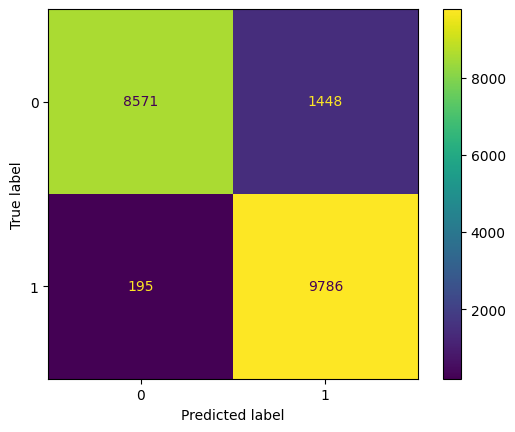

In [58]:
cm = confusion_matrix(true, np.round(pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [59]:
print(classification_report(true, np.round(pred)))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91     10019
           1       0.87      0.98      0.92      9981

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [60]:
precision, recall, thresholds = precision_recall_curve(true, pred)
pr_auc = auc(recall, precision)
pr_auc

0.9823480677025094

In [61]:
roc_auc_score(true, pred)

0.9852822618689654

# Evaluate on manually labelled data

In [24]:
new_model = build_model()

new_model.load_state_dict(torch.load('./model_weights/sentiment_model_weights.pth',map_location=torch.device('cpu')))
new_model = new_model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
new_model.eval()
pred = []
true = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k!='labels' and k!='__index_level_0__'}
        target = F.one_hot(batch['labels'], num_classes=2).to(torch.float)
        outputs = new_model(**inputs).logits.detach().cpu().numpy()

        pred.append(outputs[:, 1])
        true.append(batch['labels'].numpy())

    true = np.hstack(true)
    pred = np.hstack(pred)
    precision = precision_score(true, np.round(pred), average='macro')
    recall = recall_score(true, np.round(pred), average='macro')
    f1 = f1_score(true, np.round(pred), average='macro')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-measure:", f1)

  0%|          | 0/125 [00:00<?, ?it/s]/Users/shaojieee/.pyenv/versions/3.10.11/envs/info_retrieval/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 125/125 [00:05<00:00, 22.40it/s]

Precision: 0.9235741039305215
Recall: 0.913
F-measure: 0.912453623061527


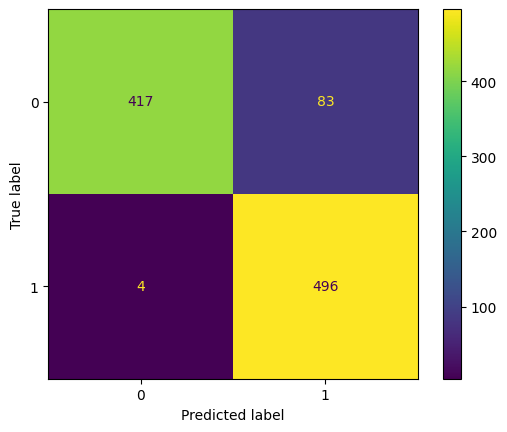

In [26]:
cm = confusion_matrix(true, np.round(pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [27]:
print(classification_report(true, np.round(pred)))

              precision    recall  f1-score   support

           0       0.99      0.83      0.91       500
           1       0.86      0.99      0.92       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



In [28]:
precision, recall, thresholds = precision_recall_curve(true, pred)
pr_auc = auc(recall, precision)
pr_auc

0.9897152707086141

In [29]:
roc_auc_score(true, pred)

0.989566

# Predicting on crawled data

In [11]:
data = pd.read_csv('../crawling/raw-v2/combined.csv')
data.head()

,Name,Rating,Review,Restaurant,Business_Status,Formatted_Address,Place_Id,Types,User_Ratings_Total,Latlng
0,Alati Divine Greek Cuisine,4.5,Loved the ambience !,Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476"
1,Alati Divine Greek Cuisine,4.5,"Food was great . Salted baked fish , prawns an...",Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476"
2,Alati Divine Greek Cuisine,4.5,The food is spectacular. We were sharing about...,Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476"
3,Alati Divine Greek Cuisine,4.5,Yummy authentic Greek food. The dips were real...,Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476"
4,Alati Divine Greek Cuisine,4.5,Pretty good food. =),Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476"


In [12]:
dataset = pd.DataFrame(data[['Review']])

In [13]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
def tokenize_function(examples, col):
    return tokenizer(examples[col], padding=True, truncation=True, max_length=512,return_tensors='pt')

In [14]:
dataset = Dataset.from_pandas(dataset)

In [15]:
dataset = dataset.map(lambda x:tokenize_function(x,'Review'), batched=True)

Map: 100%|██████████| 59191/59191 [00:02<00:00, 21899.57 examples/s]


In [16]:
dataset = dataset.remove_columns(['Review'])
dataset.set_format('torch')

In [17]:
dataloader = DataLoader(dataset, shuffle=False, batch_size=8)

In [21]:
new_model = build_model()
new_model.load_state_dict(torch.load('./model_weights/sentiment_model_weights.pth',map_location=torch.device('cpu')))
new_model = new_model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
new_model.eval()
pred = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k!='labels' and k!='__index_level_0__'}
        outputs = new_model(**inputs).logits.detach().cpu().numpy()
        pred.append(outputs[:, 1])
        
    pred = np.hstack(pred)

  0%|          | 0/7399 [00:00<?, ?it/s]/Users/shaojieee/.pyenv/versions/3.10.11/envs/info_retrieval/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 7399/7399 [05:37<00:00, 21.91it/s]


In [23]:
data['polarity_probability'] = pred
data['polarity'] = np.round(pred)

data['polarity'] = data['polarity'].replace({1:'POSITIVE', 0:'NEGATIVE'})

data.head()

,Name,Rating,Review,Restaurant,Business_Status,Formatted_Address,Place_Id,Types,User_Ratings_Total,Latlng,polarity_probability,polarity
0,Alati Divine Greek Cuisine,4.5,Loved the ambience !,Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476",0.999407,POSITIVE
1,Alati Divine Greek Cuisine,4.5,"Food was great . Salted baked fish , prawns an...",Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476",0.967735,POSITIVE
2,Alati Divine Greek Cuisine,4.5,The food is spectacular. We were sharing about...,Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476",0.999428,POSITIVE
3,Alati Divine Greek Cuisine,4.5,Yummy authentic Greek food. The dips were real...,Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476",0.999319,POSITIVE
4,Alati Divine Greek Cuisine,4.5,Pretty good food. =),Alati Divine Greek Cuisine,OPERATIONAL,"73 Amoy St, Singapore 069892",ChIJn0mYZQ0Z2jERomxAoOxa4zI,"restaurant,food,point_of_interest,establishment",695,"1.2803412,103.8467476",0.999002,POSITIVE


In [24]:
data.to_csv('./results/reviews_labelled.csv')